In [287]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
import hython

import os
import xarray as xr
import random 
import numpy as np
from pathlib import Path 
import glob

from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

# Eurac utils
from hython.preprocess import preprocess, apply_normalization
from hython.models.lstm import CustomLSTM, CudnnLSTM
from hython.metrics import RMSELoss
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler
from hython.viz import plot_sampler
from hython.utils import missing_location_idx, reconstruct_from_missing

# visualize 
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy import crs as ccrs

import warnings
warnings.filterwarnings("ignore")

In [289]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

In [61]:
## user settings

domain = "demo" # "alps"

timeslice = None # slice("2016-01-01","2020-12-31")


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc"] #  ,"actevap" ] # "q_river"]


In [ ]:
if domain == "demo":
    dyn_vars_ds = xr.open_dataset('../data/dyn_vars.nc',decode_coords='all', chunks= {"time":100})#.to_dataset(dim='variable')
    static_params_ds = xr.open_dataset('../data/staticmaps_calibrated_parameters.nc',decode_coords='all', chunks= {"time":100}).sel(layer=1)#.to_dataset(dim='variable')
    target_ds = xr.open_dataset('../data/soil_moisture_2019.nc',decode_coords='all', chunks= {"time":100}).isel(lat=slice(None, None, -1))

    target_ds = target_ds.rename_vars({"vwc_percroot":"vwc"})
    dyn_vars_ds.dims, static_params_ds.dims, target_ds.dims

In [63]:
if timeslice:
    dyn_vars_ds = dyn_vars_ds.sel(time=timeslice)
    target_ds = target_ds.sel(time=timeslice)
    target_ds.dims,dyn_vars_ds.dims

In [64]:
intervals = (10, 10)
train_origin = (0, 0)
valid_origin =  (3, 3)
test_origin =  (9, 9)

remove_lakes = False
compute = True
save = False

In [65]:
# mask lakes

if remove_lakes:
    mask_lakes = (target_ds.mean(dim = "time")["actevap"] == 0).astype(np.bool_)
    target_ds = target_ds.where(~mask_lakes, np.nan)
    dyn_vars_ds = dyn_vars_ds.where(~mask_lakes, np.nan)
    static_params_ds = static_params_ds.where(~mask_lakes, np.nan)

if domain == "demo":
    targets_nan = (np.isnan(target_ds.mean(dim="time"))).astype(np.bool_)
    
    target_ds = target_ds.where(~targets_nan, np.nan)
    static_params_ds = static_params_ds.where(~targets_nan.vwc, np.nan)

In [66]:
if compute: 
    Xd, Xs, Y, dims, meta = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       # sampler = RegularIntervalSampler(
                       #              intervals = intervals,
                       #              origin = train_origin
                       # )
                       )
    Xd_valid, Xs_valid, Y_valid, dims_valid, meta_valid = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       # sampler = RegularIntervalSampler(
                       #     intervals = intervals,
                       #     origin = valid_origin),
                       )
else:
    loaded = np.load(f'/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/grid_{intervals[0]}_{train_origin[0]}_{valid_origin[0]}.npz',
                    allow_pickle=True)
    for ff in loaded.files:
        print(ff)
        if "dims" in ff:
            exec(f"{ff}=loaded['{ff}'].tolist()")
        else:
            exec(f"{ff}=loaded['{ff}']")

dynamic:  (52430, 365, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (52430, 8)  => (GRIDCELL, FEATURE)
target:  (52430, 365, 1)  => (GRIDCELL, TIME, TARGET)
dynamic:  (52430, 365, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (52430, 8)  => (GRIDCELL, FEATURE)
target:  (52430, 365, 1)  => (GRIDCELL, TIME, TARGET)


In [12]:
if save:
    np.savez_compressed(f'/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/grid_{intervals[0]}_{train_origin[0]}_{valid_origin[0]}'
                    , Xd=Xd, Xs=Xs, Y=Y, dims=dims, Xd_valid=Xd_valid, Xs_valid=Xs_valid,
                       Y_valid=Y_valid, dims_valid=dims_valid, meta=meta, meta_valid=meta_valid)

In [67]:
Y = Y[:,:,[0]]
Y_valid = Y_valid[:,:,[0]]
Y.shape,Xs.shape

((52430, 365, 1), (52430, 8))

In [68]:
idx = missing_location_idx(Xs)
idx_valid = missing_location_idx(Xs_valid)
Xd_clean = Xd[~idx]
Xs_clean = Xs[~idx]
Y_clean = Y[~idx]

Xd_valid_clean = Xd_valid[~idx_valid]
Xs_valid_clean = Xs_valid[~idx_valid]
Y_valid_clean = Y_valid[~idx_valid]

In [69]:
Xd_clean, d_m, d_std = apply_normalization(Xd_clean, type = "spacetime", how ='standard')
Xs_clean, s_m, s_std = apply_normalization(Xs_clean, type = "space", how ='standard')
Xd_valid_clean = apply_normalization(Xd_valid_clean, type = "spacetime", how ='standard', m = d_m, std = d_std)
Xs_valid_clean = apply_normalization(Xs_valid_clean, type = "space", how ='standard', m = s_m, std = s_std)

In [70]:
Xs_clean = torch.Tensor(Xs_clean)
Xs_valid_clean = torch.Tensor(Xs_valid_clean)

Xd_clean = torch.Tensor(Xd_clean)
Xd_valid_clean = torch.Tensor(Xd_valid_clean)

Y_clean = torch.Tensor(Y_clean)
Y_valid_clean = torch.Tensor(Y_valid_clean)

In [71]:
nx = Xd.shape[-1] + Xs.shape[-1]
ny = Y.shape[-1]
nx, ny

(11, 1)

In [72]:
spatial_batch_size =  256 # int(512 / 4)
temporal_sampling_size = 120
seq_length = 60

In [73]:
train_dataset = LSTMDataset(Xd_clean, Y_clean, Xs_clean)

In [74]:
val_dataset = LSTMDataset(Xd_valid_clean, Y_valid_clean, Xs_valid_clean)

In [75]:
train_loader = DataLoader(train_dataset, batch_size=spatial_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=spatial_batch_size, shuffle=False)

In [76]:
hidden_size = 64

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": Y.shape[-1], # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_params

{'input_size': 3,
 'hidden_size': 64,
 'output_size': 1,
 'number_static_predictors': 8}

In [77]:
model = CustomLSTM(model_params)
#model = CudnnLstmModel(nx = nx, ny =  ny, hiddenSize =  hidden_size)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=64, bias=True)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [78]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output, target, squared=True)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

In [79]:
epochs = 10

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device

}

type(model)

hython.models.lstm.CustomLSTM

In [81]:
model.load_state_dict(torch.load(params_train["path2weights"]))

<All keys matched successfully>

# Plots

In [245]:
from hython.utils import predict, reconstruct_from_missing, reshape_to_2Dspatial, to_xr
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare

In [ ]:
yhat = predict(Xd_clean, Xs_clean, model, spatial_batch_size, device)

yhat = reconstruct_from_missing(
                                yhat, 
                                Y.shape, 
                                idx
    )

lat, lon, time = *dims["orig"][:2], Y.shape[1]

yhat = reshape_to_2Dspatial(
    yhat,
    lat,
    lon,
    time, 
    1)

y = reshape_to_2Dspatial(
    Y,
    lat,
    lon,
    time,
    1)

y = to_xr(y[...,0], coords = dict(target_ds.coords))
yhat = to_xr(yhat[...,0], coords = dict(target_ds.coords))

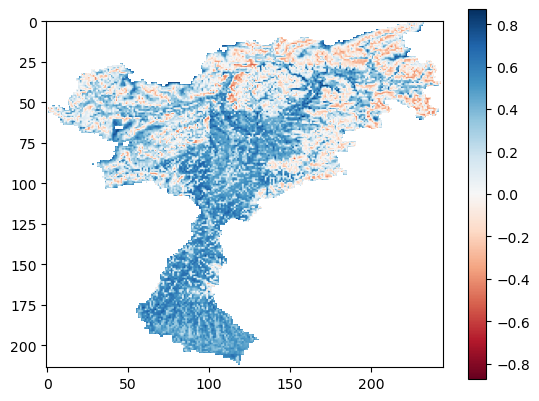

In [252]:
map_pearson(y, yhat)

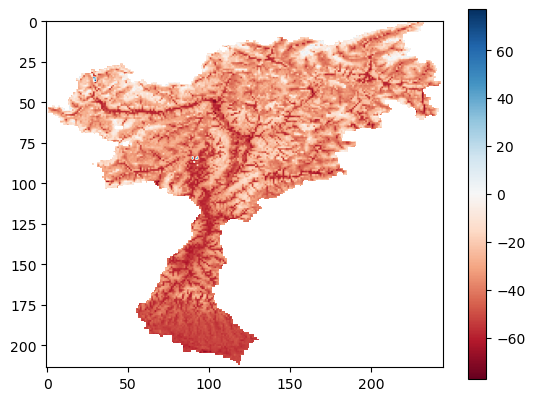

In [253]:
map_pbias(y, yhat*100)

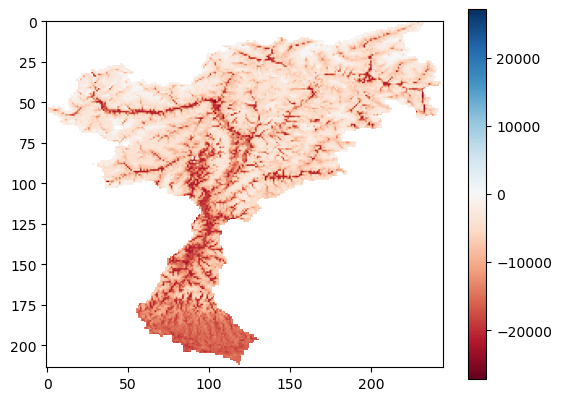

In [254]:
map_bias(y, yhat*100)

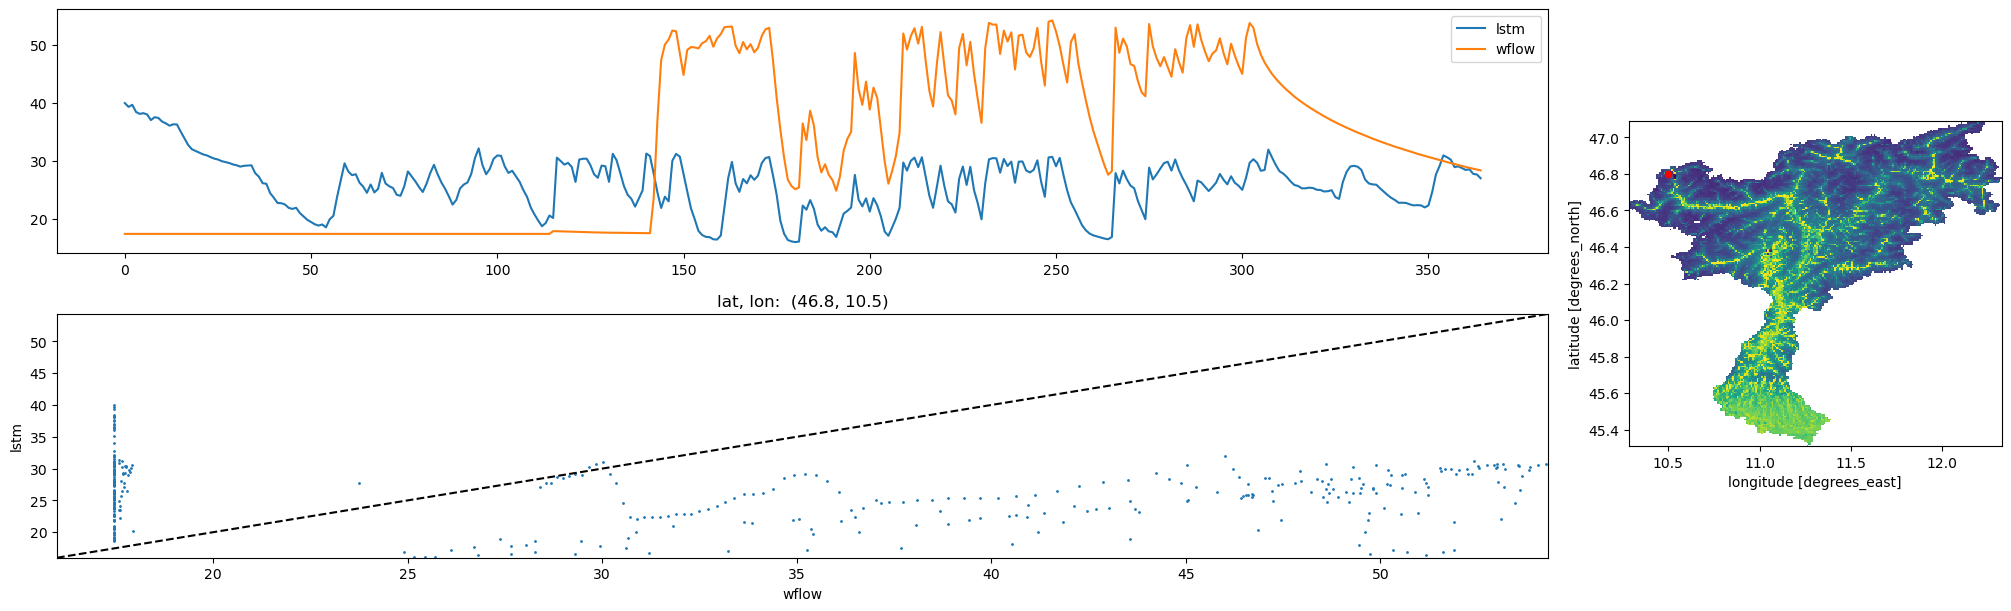

In [285]:
ts_compare(y, yhat*100, lat = [46.8], lon = [10.5])

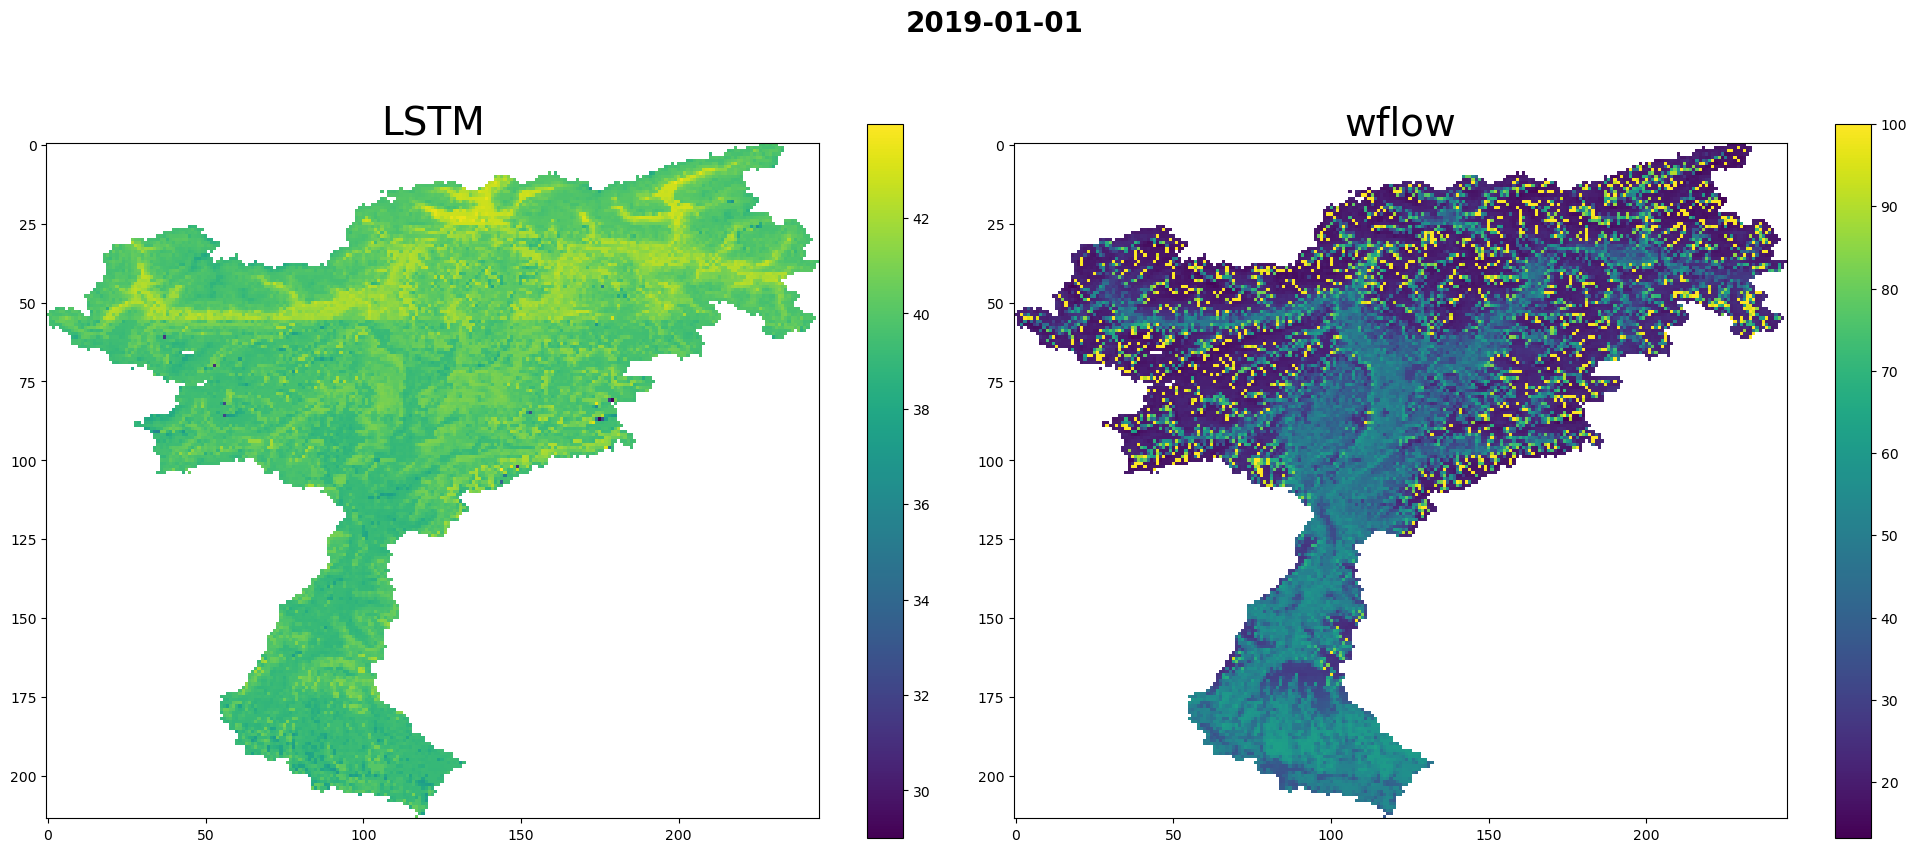

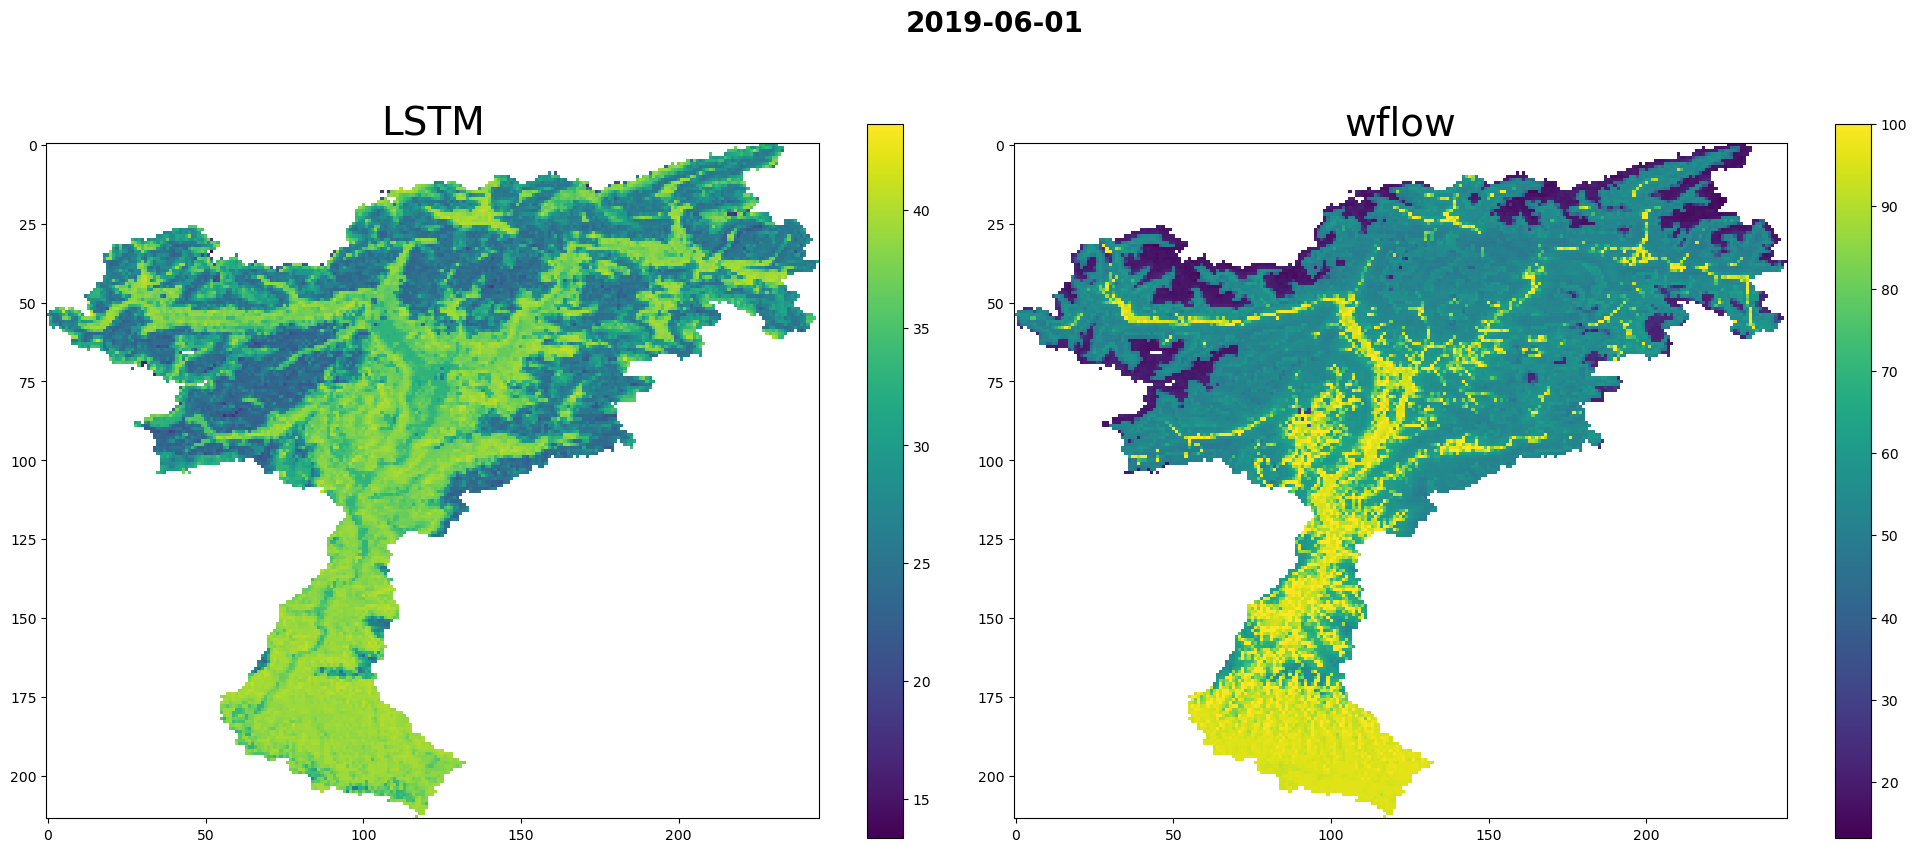

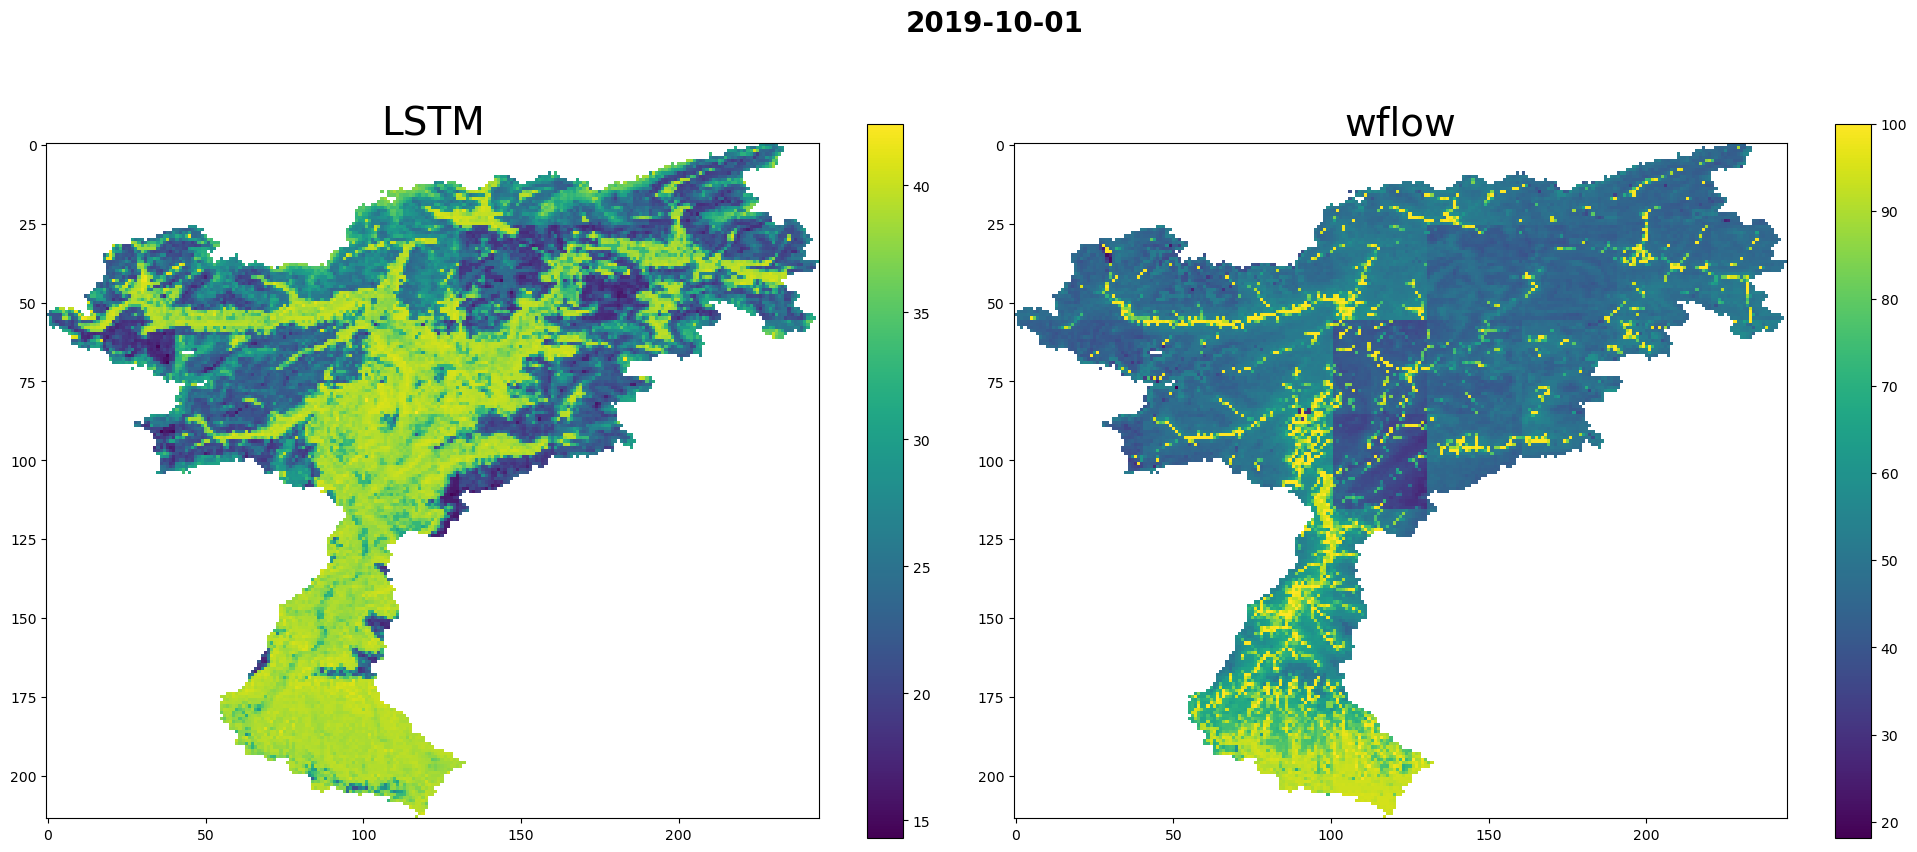

In [286]:
map_at_timesteps(y, yhat*100, 
                dates=["2019-01-01", "2019-06-01","2019-10-01"])